# Image Classification

今回は、Kaggleで公開されている[肺炎のデータセット](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)を使って、画像分類を実際に行って行きたいと思います．

### パッケージのインポート
モデルの構築に必要なTensorflowとKerasのクラスをインポートします．

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

## データセット

### データセットの読み込み

ルートパスの設定

In [2]:
root_path = "/content/drive/My Drive/AI医療入門/Materials/秋学期/" # .ipynbファイルが保存されている場所(自分の環境に合わせて書き換える)
print(os.path.exists(root_path))

True


データセットのディレクトリ構成は以下のようになっています．



<pre>
<b>chest_xray</b>
|___<b>train</b>
     |___NORMAL    : [*.jpeg, ...]
     |___PNEUMONIA : [*.jpeg, ...]
|___<b>test</b>
     |___NORMAL    : [*.jpeg, ...]
     |___PNEUMONIA : [*.jpeg, ...]
|___<b>val</b>
     |___NORMAL    : [*.jpeg, ...]
     |___PNEUMONIA : [*.jpeg, ...]
</pre>




#### データセットのロード

In [3]:
import glob

# トレーニングデータセット
train_dir = os.path.join(root_path, "chest_xray/train")
train_normal_dir = os.path.join(train_dir, "normal")
train_abnormal_dir = os.path.join(train_dir, "pneumonia")

# テストデータセット
test_dir = os.path.join(root_path, "chest_xray/test")
test_normal_dir = os.path.join(test_dir, "normal")
test_abnormal_dir = os.path.join(test_dir, "pneumonia")

In [4]:
num_normal_train = len(os.listdir(train_normal_dir))
num_abnormal_train = len(os.listdir(train_abnormal_dir))

num_normal_test = len(os.listdir(test_normal_dir))
num_abnormal_test = len(os.listdir(test_abnormal_dir))

total_train = num_normal_train + num_abnormal_train
total_test = num_normal_test + num_abnormal_test
print("train dataset")
print(f"normal : {num_normal_train}, abnormal : {num_abnormal_train}")
print("test dataset")
print(f"normal : {num_normal_test}, abnormal : {num_abnormal_test}")
print("----")
print(f"total train image : {total_train}")
print(f"total test image : {total_test}")

train dataset
normal : 1000, abnormal : 1000
test dataset
normal : 500, abnormal : 500
----
total train image : 2000
total test image : 1000


データセットの前処理及びネットワークの学習の際に用いる変数を定義しておきます．

In [5]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

### データの準備

1.   画像を読み取る
2.   これらの画像のコンテンツをデコードし、RGB値にしたがって適切なグリッド形式に変換する
3.   それらを浮動小数点テンソルに変換する
4.   ニューラルネットワークは小さな入力値を扱う方が適しているため、テンソルを0〜255の値から0〜1の値にリスケーリングする．


In [6]:
train_image_generator = ImageDataGenerator(rescale=1./255) # トレーニングデータのジェネレータ
test_image_generator = ImageDataGenerator(rescale=1./255) # テストデータのジェネレータ

画像をロードして、リスケーリングを適用、そして、画像サイズを変換する．

In [7]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size, 
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [8]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                        directory=test_dir,
                                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                        class_mode='binary')

Found 1000 images belonging to 2 classes.


### 学習用画像の可視化

`next` 関数はデータセットからバッチを返します。 `next` 関数の返り値は `（x_train、y_train）` の形式で、 `x_train` は学習用の特徴量、 `y_train` はそのラベルです。ラベルを破棄して、学習用画像の可視化のみを行います。

In [9]:
# この関数は、1行5列のグリッド形式で画像をプロットし、画像は各列に配置されます。
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [10]:
sample_training_images, _ = next(train_data_gen) # 少し時間がかかります．

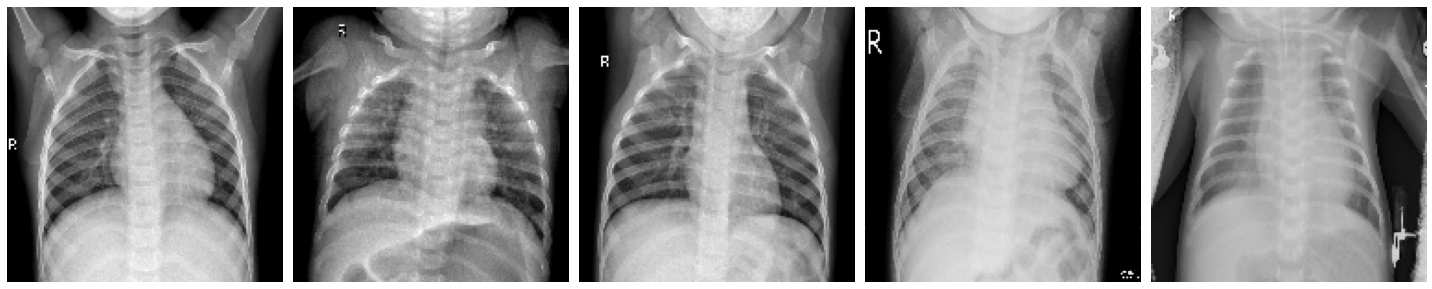

In [11]:
plotImages(sample_training_images[:5])

## モデルの構築

In [12]:
image_gen = ImageDataGenerator(rescale=1./255, vertical_flip=True)

In [13]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode='binary')

Found 2000 images belonging to 2 classes.


In [14]:
image_gen_test = ImageDataGenerator(rescale=1./255)

In [15]:
val_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
                                                 directory=test_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


In [16]:
from tensorflow.keras import applications
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [17]:
base_model_resnet = applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=[IMG_HEIGHT, IMG_WIDTH, 3])
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
print(x.shape)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions)
for layer in base_model_resnet.layers:
  layer.trainable = False

234553344/234545216 [==============================] - 2s 0us/step
(None, 2048)


In [18]:
model_resnet.compile(
  optimizer="adam",
  loss='binary_crossentropy',
  metrics=['accuracy']
)

In [19]:
history_resnet = model_resnet.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_test // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
15/15 [==============================] - 1295s 86s/step - loss: 0.6990 - accuracy: 0.7879 - val_loss: 0.7350 - val_accuracy: 0.8304
Epoch 2/15
15/15 [==============================] - 43s 3s/step - loss: 0.2635 - accuracy: 0.9209 - val_loss: 0.3454 - val_accuracy: 0.8951
Epoch 3/15
15/15 [==============================] - 44s 3s/step - loss: 0.1618 - accuracy: 0.9380 - val_loss: 0.2621 - val_accuracy: 0.9074
Epoch 4/15
15/15 [==============================] - 43s 3s/step - loss: 0.1481 - accuracy: 0.9476 - val_loss: 0.2721 - val_accuracy: 0.9062
Epoch 5/15
15/15 [==============================] - 44s 3s/step - loss: 0.1309 - accuracy: 0.9514 - val_loss: 0.2769 - val_accuracy: 0.9062
Epoch 6/15
15/15 [==============================] - 44s 3s/step - loss: 0.1278 - accuracy: 0.9557 - val_loss: 0.2569 - val_accuracy: 0.9196
Epoch 7/15
15/15 [==============================] - 43s 3s/step - loss: 0.1140 - 

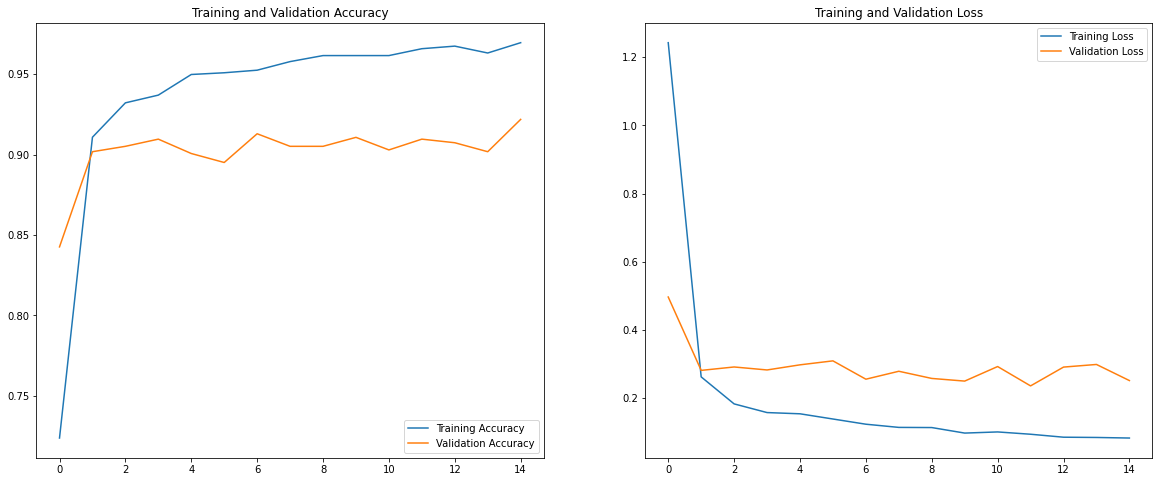

In [ ]:
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']

loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
base_model_vgg = applications.VGG16(weights='imagenet', include_top=False, input_shape=[IMG_HEIGHT, IMG_WIDTH, 3])
x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
print(x.shape)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model_vgg = Model(inputs=base_model_vgg.input, outputs=predictions)
for layer in base_model_vgg.layers:
  layer.trainable = False

(None, 512)


In [ ]:
model_vgg.compile(
  optimizer="adam",
  loss='binary_crossentropy',
  metrics=['accuracy']
)

In [ ]:
history_vgg = model_vgg.fit_generator(
  train_data_gen,
  steps_per_epoch=total_train // batch_size,
  epochs=epochs,
  validation_data=val_data_gen,
  validation_steps=total_test // batch_size
)

Epoch 1/15
15/15 [==============================] - 278s 19s/step - loss: 0.5227 - accuracy: 0.7751 - val_loss: 0.4072 - val_accuracy: 0.8504


Exception ignored in: <bound method IteratorResourceDeleter.__del__ of <tensorflow.python.data.ops.iterator_ops.IteratorResourceDeleter object at 0x7f8268277d30>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 537, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1279, in delete_iterator
    tld.op_callbacks, handle, deleter)
KeyboardInterrupt: 


Epoch 2/15
15/15 [==============================] - 39s 3s/step - loss: 0.3495 - accuracy: 0.8632 - val_loss: 0.3000 - val_accuracy: 0.8817
Epoch 3/15
15/15 [==============================] - 39s 3s/step - loss: 0.2821 - accuracy: 0.8926 - val_loss: 0.2964 - val_accuracy: 0.8828
Epoch 4/15
15/15 [==============================] - 38s 3s/step - loss: 0.2592 - accuracy: 0.9038 - val_loss: 0.2808 - val_accuracy: 0.8862
Epoch 5/15
15/15 [==============================] - 38s 3s/step - loss: 0.2372 - accuracy: 0.9124 - val_loss: 0.2590 - val_accuracy: 0.8917
Epoch 6/15
15/15 [==============================] - 38s 3s/step - loss: 0.2276 - accuracy: 0.9177 - val_loss: 0.2649 - val_accuracy: 0.8850
Epoch 7/15
15/15 [==============================] - 39s 3s/step - loss: 0.2190 - accuracy: 0.9161 - val_loss: 0.2655 - val_accuracy: 0.8817
Epoch 8/15
15/15 [==============================] - 38s 3s/step - loss: 0.2098 - accuracy: 0.9247 - val_loss: 0.2309 - val_accuracy: 0.9085
Epoch 9/15
15/15 [==

In [ ]:
acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']

loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()